# **EDA : Exploratory Data Analysis**

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Fake and real news dataset

https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

 83% 34.0M/41.0M [00:01<00:00, 23.4MB/s]
100% 41.0M/41.0M [00:01<00:00, 23.8MB/s]


In [ ]:
!unzip fake-and-real-news-dataset

Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-07-24 16:49:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-24 16:49:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-24 16:49:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
import re
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding , LSTM
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
warnings.filterwarnings('ignore')

#from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
#stop_words = set(stopwords.words('english'))

import gensim
from gensim.parsing.preprocessing import remove_stopwords


In [ ]:
real = pd.read_csv("True.csv")
fake = pd.read_csv("Fake.csv", parse_dates=False)

### **Exploring Real news**

In [ ]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [ ]:
real.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [ ]:
print(real["subject"].unique())


['politicsNews' 'worldnews']


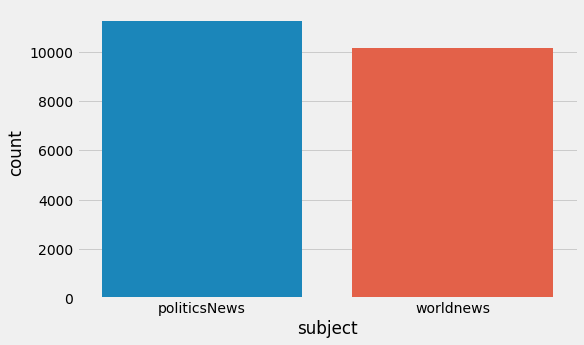

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=real)
plt.show()

In [ ]:
real['year'] = real['date'].str[-5:]

In [ ]:
real = real.drop(columns=["date"])

In [ ]:
print(real["year"].unique())

['2017 ' '2016 ']


In [ ]:
real.head()

,title,text,subject,year
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017


In [ ]:
real.groupby("year")["text"].transform("count")

0        16701
1        16701
2        16701
3        16701
4        16701
         ...  
21412    16701
21413    16701
21414    16701
21415    16701
21416    16701
Name: text, Length: 21417, dtype: int64

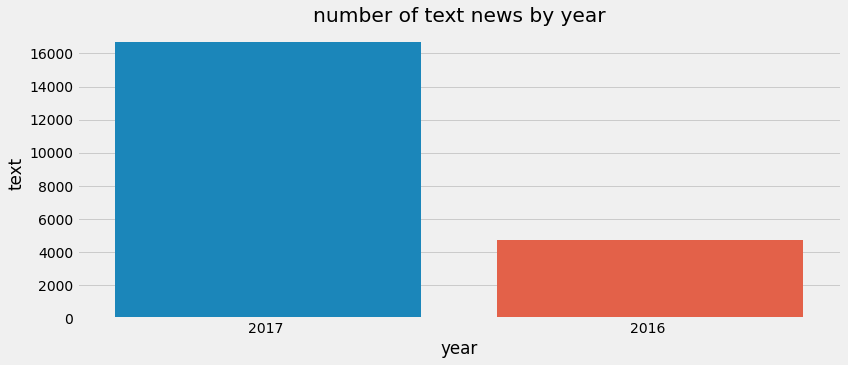

In [ ]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(x=real['year'], y=real.groupby("year")["text"].transform("count"))
plt.tight_layout()
plt.title('number of text news by year')
plt.show()

In [ ]:
df = real.groupby(['year', 'subject']).agg({'text': 'count'})

In [ ]:
df = df.reset_index(level=['year', 'subject'])

Text(0.5, 1.0, 'text news by year and by subject')

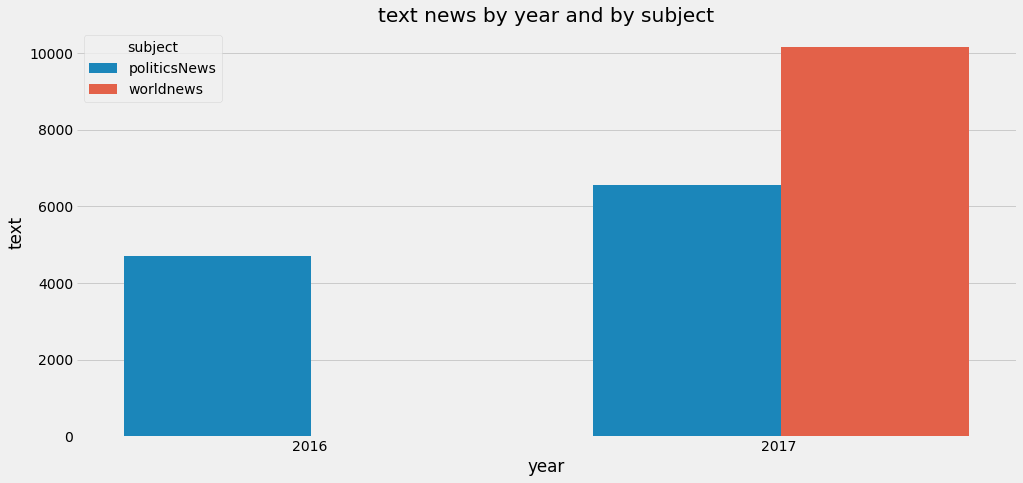

In [ ]:
plt.figure(figsize=(15,7))
plt.box(False)
sns.barplot(data=df, x='year', y='text', hue='subject')
plt.title("text news by year and by subject")

In [ ]:
# delate empty text 
real.drop(real[real.text.str.isspace()].index, inplace=True)

In [ ]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21416 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21416 non-null  object
 1   text     21416 non-null  object
 2   subject  21416 non-null  object
 3   year     21416 non-null  object
dtypes: object(4)
memory usage: 836.6+ KB


In [ ]:
# delate publishers from text
real['text'] = real['text'].str.split(r" -").str.get(1)

In [ ]:
real.head()

,title,text,subject,year
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,2017
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,2017
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,2017
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,2017
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,2017


In [ ]:
# combine title and text columns
real['text'] = real['title'] + " " +real['text']

In [ ]:
# Drop the columns "title","subject","year"
real = real.drop(columns=["title","subject","year"])

In [ ]:
real["class"] = 1

In [ ]:
real.head()

,text,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


### **Exploring Fake News**

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [ ]:
print(fake["subject"].unique())

['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


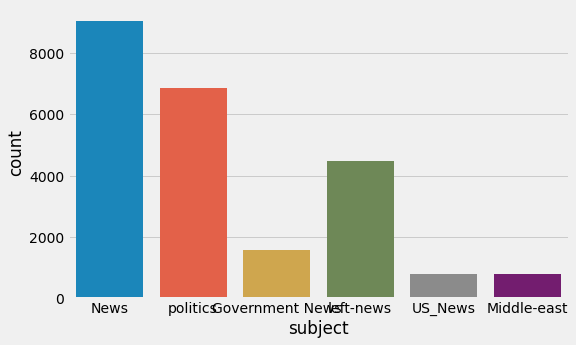

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=fake)
plt.show()

In [ ]:
fake['year'] = fake['date'].str[-4:]

In [ ]:
fake = fake.drop(columns=["date"])

In [ ]:
fake['year'] = fake[fake.year.apply(lambda x: x.isnumeric())]['year']

In [ ]:
fake.dropna(subset = ["year"], inplace=True)

In [ ]:
print(fake["year"].unique())

['2017' '2016' '2015']


In [ ]:
fake.groupby("year")["text"].transform("count")

0         9203
1         9203
2         9203
3         9203
4         9203
         ...  
23476    11754
23477    11754
23478    11754
23479    11754
23480    11754
Name: text, Length: 23436, dtype: int64

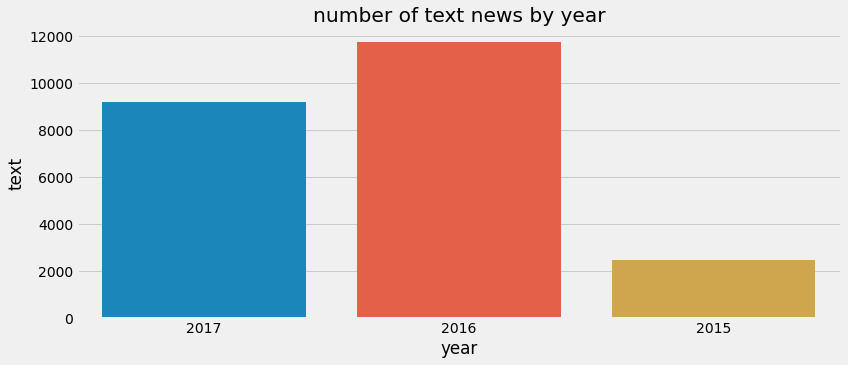

In [ ]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(x=fake['year'], y=fake.groupby("year")["text"].transform("count"))
plt.tight_layout()
plt.title('number of text news by year')
plt.show()

In [ ]:
df = fake.groupby(['year', 'subject']).agg({'text': 'count'})

In [ ]:
df = df.reset_index(level=['year', 'subject'])

Text(0.5, 1.0, 'text news by year and by subject')

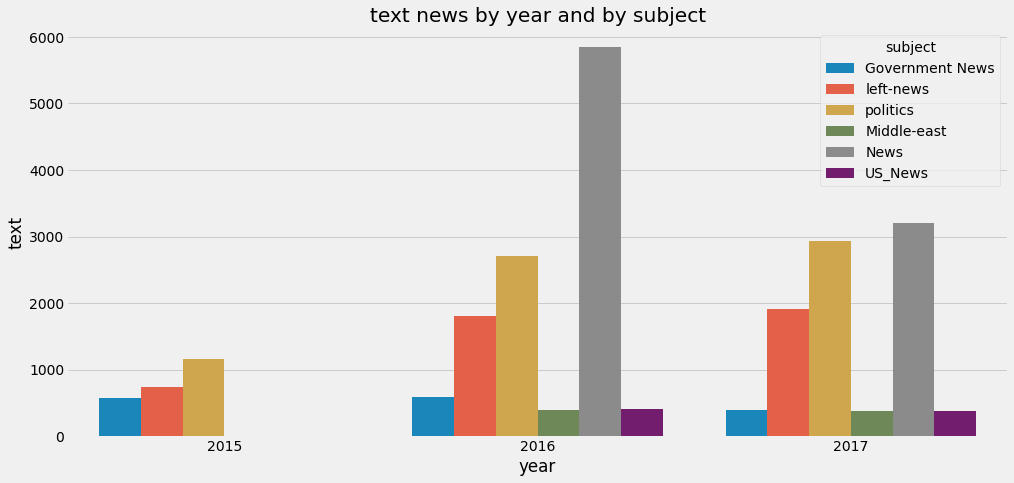

In [ ]:
plt.figure(figsize=(15,7))
plt.box(False)
sns.barplot(data=df, x='year', y='text', hue='subject')
plt.title("text news by year and by subject")

In [ ]:
# delate empty text 
fake.drop(fake[fake.text.str.isspace()].index, inplace=True)

In [ ]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22806 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    22806 non-null  object
 1   text     22806 non-null  object
 2   subject  22806 non-null  object
 3   year     22806 non-null  object
dtypes: object(4)
memory usage: 890.9+ KB


In [ ]:
# combine title and text columns
fake['text'] = fake['title'] + " " +fake['text']

In [ ]:
# Drop the columns "title","subject","year"
fake = fake.drop(columns=["title","subject","year"])

In [ ]:
fake["class"] = 0

In [ ]:
fake.head()

,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


**concatenate two dataframes**

In [ ]:
data = pd.concat([real,fake],ignore_index=False)

In [ ]:
data.head()

,text,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44222 entries, 0 to 23480
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44202 non-null  object
 1   class   44222 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [ ]:
data.to_csv('out.csv',index=False)

In [ ]:
del real,fake

In [ ]:
df = pd.read_csv("out.csv")

In [ ]:
df.tail()

,text,class
44217,McPain: John McCain Furious That Iran Treated ...,0
44218,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,0
44219,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,0
44220,How to Blow $700 Million: Al Jazeera America F...,0
44221,10 U.S. Navy Sailors Held by Iranian Military ...,0


In [ ]:
df.loc[df['class']==0,'class'].agg(['count'])

count    22806
Name: class, dtype: int64

In [ ]:
df.loc[df['class']==1,'class'].agg(['count'])

count    21416
Name: class, dtype: int64

##Preprocessing Text

In [ ]:
# convert test col to string
df['text']=df['text'].astype(str)

In [ ]:
#len(stop_words)

In [ ]:
'''
def Removing_StopWords(text):
  #text = "Nick likes to play football, however he is not too fond of tennis."
  text_tokens = word_tokenize(text)
  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
  return (" ").join(tokens_without_sw)

df['text'] = df['text'].apply(lambda x: Removing_StopWords(x))
'''

'\ndef Removing_StopWords(text):\n  #text = "Nick likes to play football, however he is not too fond of tennis."\n  text_tokens = word_tokenize(text)\n  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]\n  return (" ").join(tokens_without_sw)\n\ndf[\'text\'] = df[\'text\'].apply(lambda x: Removing_StopWords(x))\n'

In [ ]:
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [ ]:
#all_stopwords = gensim.parsing.preprocessing.STOPWORDS
#len(all_stopwords)

In [ ]:
df.head()

,text,class
0,us budget fight looms republicans flip fiscal ...,1
1,us military accept transgender recruits monday...,1
2,senior us republican senator let mr mueller jo...,1
3,fbi russia probe helped australian diplomat ti...,1
4,trump wants postal service charge much more am...,1


In [ ]:
nos = np.array([len(x) for x in X])

##Tokenizing Text

In [ ]:
#Count number of words per row
count = df['text'].str.split(' ').str.len()

In [ ]:
max_fatures = 3000
output_vector = 100
max_length = int(count.mean()) #Counting Avg Number of Words Per row
dropout_rate = 0.5
no_epochs = 30
batch_size = 64

In [ ]:
# input
#Repsesenting each word by a number ( numerical representation )
# take the most 3000 frequent words in data
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)
# convert words to list of 217 numbers 
X = pad_sequences(X, maxlen=max_length, truncating="post")

In [ ]:
print('Found %d unique words.' % len(tokenizer.word_index))

Found 223393 unique words.


## Embedding

Word embedding is the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

In [ ]:
path_to_glove_file = "/content/glove.6B.100d.txt"

In [ ]:
# Creating Embedding Dictionary

embedding_dict={}
with open(path_to_glove_file,'r', encoding='utf8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [ ]:
# Creating embedding matrix with GloVe using enbedding_dict we created above
#num_words=len(word_index)+1
# matrix (3000 * 100)
embedding_matrix=np.zeros((max_fatures,output_vector))

In [ ]:
embedding_dict.get('trump')

array([-0.15731 , -0.75503 ,  0.36845 , -0.18958 , -0.16896 , -0.23157 ,
       -0.22658 , -0.30186 ,  0.24372 ,  0.61896 ,  0.58995 ,  0.047638,
       -0.055164, -0.70211 ,  0.22084 , -0.69232 ,  0.49419 ,  1.4285  ,
       -0.25362 ,  0.20031 , -0.26192 ,  0.05315 , -0.048418, -0.44982 ,
        0.54644 , -0.014645, -0.015531, -0.61197 , -0.91964 , -0.7528  ,
        0.64843 ,  1.0934  ,  0.052682,  0.33345 ,  0.10532 ,  0.59517 ,
        0.023104, -0.37105 ,  0.29749 , -0.23683 ,  0.079566, -0.10326 ,
        0.35885 , -0.28935 , -0.19881 ,  0.22908 , -0.061435,  0.56127 ,
       -0.017115, -0.32868 , -0.78417 , -0.49375 ,  0.34944 ,  0.16278 ,
       -0.061168, -1.3106  ,  0.39152 ,  0.124   , -0.20873 , -0.18473 ,
       -0.56184 ,  0.55693 ,  0.012114, -0.54545 , -0.31409 ,  0.1     ,
        0.31543 ,  0.74757 , -0.47734 , -0.18332 , -0.65623 ,  0.40768 ,
       -0.30697 , -0.47247 , -0.7421  , -0.44978 , -0.078122, -0.52673 ,
       -0.70633 ,  1.3271  ,  0.26298 , -0.91    , 

In [ ]:
# take 3000 from 223393
for i, (word, count) in enumerate(tokenizer.word_counts.items()): 
    if i < tokenizer.num_words-1:
      emb_vec=embedding_dict.get(word)
      if emb_vec is not None:
        embedding_matrix[i]=emb_vec

gensim

In [ ]:

text = df['text'].apply(gensim.utils.simple_preprocess)

#Creating Word Vectors by Word2Vec Method 
w2v_model = gensim.models.Word2Vec(sentences = text, size = output_vector, window=5, min_count=5)

In [ ]:
#vocab size
len(w2v_model.wv.vocab)

49153

In [ ]:
#see a sample vector for random word, lets say trump 
w2v_model["trump"]

array([-2.1016724 ,  0.39052552, -1.1430078 , -0.78830475,  0.06586853,
        0.73549366,  1.369778  , -1.6727303 , -0.49290267,  1.7898003 ,
       -0.6572072 ,  2.0420702 ,  2.2821534 ,  1.8028357 ,  1.1691525 ,
       -1.5456425 ,  0.9712795 , -0.48891824, -0.29258925, -1.7702389 ,
        0.96389246, -1.319658  , -2.641531  ,  0.13485797,  1.1228117 ,
        0.8729641 , -0.8568487 ,  0.50832695,  1.0982363 , -1.2044603 ,
        3.9647686 , -2.3685544 , -1.6329875 , -1.0901352 ,  0.31452203,
       -1.6673036 , -1.756524  ,  2.0387704 ,  2.9461033 ,  0.1376678 ,
       -1.1977463 ,  0.55342007, -0.17515182, -0.37258455,  0.31564495,
        0.59593594, -0.07038717,  0.26718703, -0.23826788,  0.9169793 ,
        3.0646002 , -1.0839218 , -0.09087887,  0.2365953 , -0.0780258 ,
       -0.5547566 ,  1.1642848 , -1.7799382 ,  1.1425906 , -1.3982021 ,
        1.1428245 ,  1.4621472 ,  1.0385926 ,  0.7951496 , -0.53859115,
       -5.2081537 ,  1.9956373 , -0.74826884,  0.18414798, -1.19

In [ ]:
w2v_model.wv.most_similar("trump")

[('trumps', 0.837651789188385),
 ('trumpthe', 0.5951592326164246),
 ('presidentelect', 0.5759882926940918),
 ('cruz', 0.5009398460388184),
 ('rumsfeld', 0.5008094906806946),
 ('he', 0.4874117374420166),
 ('trumpi', 0.4836146831512451),
 ('presidentelects', 0.481280118227005),
 ('presumptive', 0.4782177209854126),
 ('himself', 0.47662949562072754)]

## Split data

In [ ]:
# output
Y = df['class'].values

In [ ]:
# split X and Y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1,test_size=0.20,stratify=Y)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(35377, 217) (35377,)
(8845, 217) (8845,)
(35377, 217) (35377,)
(8845, 217) (8845,)


In [ ]:
# Design Neural Network Architecture with SimpleRNN
print('Building Simple RNN Model..')

RNN_model = Sequential()
# Add Embedding layer
'''
Number of words in dictionary // the size of the output vector  // the length of input sequences
The Embedding has a vocabulary of 3000
The output of the Embedding layer is a 2D vector with one embedding for each word in the input sequence of words.
We will choose a small embedding space of 100 dimensions.
'''
RNN_model.add(Embedding(max_fatures, output_vector, input_length=max_length, embeddings_initializer=Constant(embedding_matrix)))
# Drops 50% of entire row
RNN_model.add(Dropout(dropout_rate))
# Add Simple RNN layer
RNN_model.add(LSTM(units = 64 , dropout=0.2, recurrent_dropout=0.2, input_shape=(max_length, output_vector)))
# Add Dense Hidden Layer
RNN_model.add(Dense(256, activation='relu'))
RNN_model.add(Dropout(dropout_rate))
RNN_model.add(Dense(128, activation='relu'))
RNN_model.add(Dropout(dropout_rate))
# Output Layer 
RNN_model.add(Dense(1, activation='sigmoid'))

Building Simple RNN Model..


In [ ]:
RNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 217, 100)          300000    
                                                                 
 dropout_9 (Dropout)         (None, 217, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dense_9 (Dense)             (None, 256)               16640     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)              

In [ ]:
# Configure model
RNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train!
print('Training the model..')
callback = EarlyStopping(monitor='val_loss', patience=5)
history = RNN_model.fit(X_train, y_train, batch_size=batch_size, verbose=2, epochs=no_epochs,validation_split=.3, callbacks=[callback])


Training the model..
Epoch 1/30
387/387 - 265s - loss: 0.4104 - accuracy: 0.8020 - val_loss: 0.2069 - val_accuracy: 0.9194 - 265s/epoch - 685ms/step
Epoch 2/30
387/387 - 262s - loss: 0.1708 - accuracy: 0.9454 - val_loss: 0.1100 - val_accuracy: 0.9707 - 262s/epoch - 678ms/step
Epoch 3/30
387/387 - 267s - loss: 0.1147 - accuracy: 0.9639 - val_loss: 0.0728 - val_accuracy: 0.9778 - 267s/epoch - 689ms/step
Epoch 4/30
387/387 - 263s - loss: 0.0818 - accuracy: 0.9756 - val_loss: 0.0805 - val_accuracy: 0.9813 - 263s/epoch - 679ms/step
Epoch 5/30
387/387 - 265s - loss: 0.0777 - accuracy: 0.9750 - val_loss: 0.0647 - val_accuracy: 0.9829 - 265s/epoch - 685ms/step
Epoch 6/30
387/387 - 270s - loss: 0.0493 - accuracy: 0.9838 - val_loss: 0.1451 - val_accuracy: 0.9699 - 270s/epoch - 699ms/step
Epoch 7/30
387/387 - 271s - loss: 0.0504 - accuracy: 0.9837 - val_loss: 0.0628 - val_accuracy: 0.9828 - 271s/epoch - 701ms/step
Epoch 8/30
387/387 - 276s - loss: 0.0413 - accuracy: 0.9873 - val_loss: 0.0446 - va

In [ ]:
# evaluate the classification model
_,acc = RNN_model.evaluate(X_test, y_test)
print("acc: %.2f" % (acc))

277/277 [==============================] - 10s 37ms/step - loss: 0.0685 - accuracy: 0.9810
acc: 0.98


In [ ]:
# confusion matrix
y_pred = RNN_model.predict(X_test,batch_size=1,verbose = 2)
y_pred = np.where(y_pred < 0.5, 0, 1)
matrix = metrics.confusion_matrix(y_pred,y_test)
print(matrix)

8845/8845 - 178s - 178s/epoch - 20ms/step
[[4495  101]
 [  67 4182]]


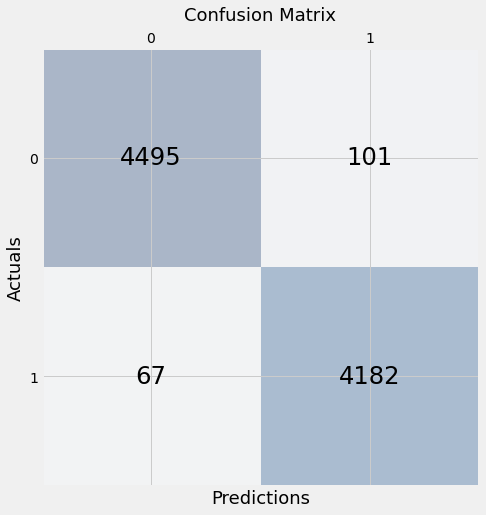

In [ ]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(x=j, y=i,s=matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

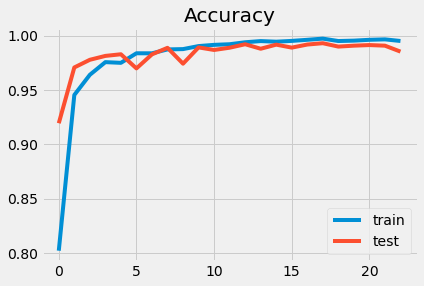

In [ ]:
# Accuracy vs Epoch
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

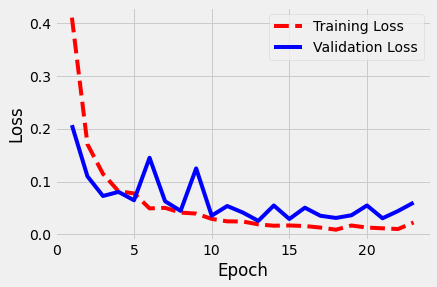

In [ ]:
# Loss vs Epoch

epoch_count = range(1, len(history.history['loss']) + 1)
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()